# Instructions
This is a clone of iiwa_tossing_jointangles_v2 but with different start and end throw jas

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy.optimize

import pydrake
from pydrake.all import (
    PiecewisePolynomial, RigidTransform, RotationMatrix, JacobianWrtVariable,
    MathematicalProgram
)

from src.drake_helpers import (
    get_basic_manip_station,
    BuildAndSimulateTrajectory, 
    setup_manipulation_station,
    visualize_transform,
    GripperControllerUsingIiwaState,
    GripperControllerUsingIiwaStateV2,
    GripperControllerUsingIiwaStateV3,
)
from src.ik import (
    create_q_knots, 
    pose_to_jointangles, 
    jointangles_to_pose, 
    spatial_velocity_jacobian_at_jointangles,
)
from src.throw import (
    plan_pickup,
    plan_prethrow_pose,
    add_go_to_ja_via_jointinterpolation,
    add_go_to_pose_via_jointinterpolation,
    plan_throw,
)
from src.trajectory import (
    get_launch_angle_required,
    get_launch_speed_required,
)

# cleaner debugging
np.set_printoptions(precision=3, suppress=True)

In [2]:
# start a single meshcat server instance to use for remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=[])
print(web_url)

http://127.0.0.1:7001/static/


In [3]:
# Initialize global plants ONCE for IK calculations
# This speed up exectuation greatly.
GLOBAL_PLANT, GLOBAL_CONTEXT = get_basic_manip_station()

# Define throw problem

In [4]:
# Get initial pose of the gripper by using default context of manip station.
P_WORLD_TARGET = np.array([-6.75, 0, 3])
MAX_APPROACH_ANGLE = -30 / 180.0 * np.pi
OBJECT_TO_TOSS = "bball" # "foam", ball", "rod", "bball"

# https://schunk.com/fileadmin/pim/docs/IM0026091.PDF - gripper frame to tip is about .115 m for reference
# GRIPPER_TO_OBJECT_FRAME_DIST = 0.12 # meters, this is how much "above" the balls origin we must send the gripper body frame in order to successfully grasp the object
# OBJECT_FRAME_TO_COM_DIST = 0.05 / 2
GRIPPER_TO_OBJECT_COM_DIST = 0.11 # 0.095 was in here before I made edits

T_world_target = RigidTransform(RotationMatrix(), P_WORLD_TARGET)
T_world_objectInitial = RigidTransform(
    #p=[-.1, -.69, 1.04998503e-01], # sphere
    p=[-0.1  , -0.69 ,  0.09], # foam_brick
    R=RotationMatrix.MakeZRotation(np.pi/2.0)
)
T_world_gripperObject = RigidTransform(
    p=T_world_objectInitial.translation() + np.array([0, 0, 0.025 + GRIPPER_TO_OBJECT_COM_DIST]),
    R=RotationMatrix.MakeXRotation(-np.pi/2.0)
)
T_world_objectCOM = RigidTransform(
    T_world_objectInitial.rotation(), 
    T_world_objectInitial.translation() + np.array([0, 0, 0.05])
)

# Set starting and ending joint angles for throw
throw_heading = np.arctan2(P_WORLD_TARGET[1], P_WORLD_TARGET[0])
ja1 = throw_heading - np.pi
# TODO: edit these to work better for large angles.
PRETHROW_JA = np.array([ja1, 0, 0, 2.1, 0, -1.9, 0, 0, 0])
THROWEND_JA = np.array([ja1, 0, 0, 0.6, 0, -0.4, 0, 0, 0])
T_world_prethrowPose = jointangles_to_pose(
    plant=GLOBAL_PLANT,
    context=GLOBAL_CONTEXT,
    jointangles=PRETHROW_JA[:7],
)

T_world_robotInitial, meshcat = setup_manipulation_station(
    T_world_objectInitial, zmq_url, T_world_target, manipuland=OBJECT_TO_TOSS, include_hoop=True
)

#object frame viz
visualize_transform(meshcat, "T_world_obj0", T_world_objectInitial)
visualize_transform(meshcat, "T_world_objectCOM", T_world_objectCOM)
visualize_transform(meshcat, "T_world_gripperObject", T_world_gripperObject)
T_world_target = RigidTransform(
    p=P_WORLD_TARGET,
    R=RotationMatrix()
)
visualize_transform(meshcat, "target", T_world_target)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.


### Compute release point via optimization
We use a scipy optimizer because a black-box optimizer is easy to implement.

In [5]:
def throw_objective(inp, g=9.81, alpha=1, return_launch_angle=False):
    throw_motion_time, release_frac = inp

    release_ja = PRETHROW_JA + release_frac * (THROWEND_JA - PRETHROW_JA)

    T_world_releasePose = jointangles_to_pose(
        plant=GLOBAL_PLANT,
        context=GLOBAL_CONTEXT,
        jointangles=release_ja[:7]
    )
    p_release = (
        T_world_releasePose.translation()
      + T_world_releasePose.rotation().multiply([0, GRIPPER_TO_OBJECT_COM_DIST, 0])
    )

    J_release = spatial_velocity_jacobian_at_jointangles(
        plant=GLOBAL_PLANT,
        context=GLOBAL_CONTEXT,
        jointangles=release_ja[:7],
        gripper_to_object_dist=GRIPPER_TO_OBJECT_COM_DIST # <==== important
    )[3:6]
    v_release = J_release @ ((THROWEND_JA - PRETHROW_JA) / throw_motion_time)[:7]

    if v_release[:2] @ (P_WORLD_TARGET - p_release)[:2] <= 0:
        return 1000
    
    x = np.linalg.norm((P_WORLD_TARGET - p_release)[:2])
    y = (P_WORLD_TARGET - p_release)[2]
    vx = np.linalg.norm(v_release[:2])
    vy = v_release[2]

    tta = x / vx
    y_hat = vy * tta - 0.5 * g * tta ** 2
    phi_hat = np.arctan((vy - g * tta) / vx)

    objective = (
        (p_release[2] + y_hat - P_WORLD_TARGET[2]) ** 2
      + np.maximum(phi_hat - MAX_APPROACH_ANGLE, 0) ** 2
      #+ (phi_hat - MAX_APPROACH_ANGLE) ** 2
      - throw_motion_time ** 2 # move a slow as possible for accuracy
    )
    
    if return_launch_angle:
        return np.arctan2(vy, vx)
    else:
        return objective

res = scipy.optimize.differential_evolution(
    throw_objective,
    bounds=[(1e-3, 3), (0.1, 0.9)],
    seed=43
)
"""
res = scipy.optimize.minimize(
    throw_objective,
    x0=np.array([0.3, 0.5]),
    method="nelder-mead",
    options={"xatol": 1e-8, "disp": False}
)
"""

#print(f"Best objective value: {throw_objective(res.x)}")
#assert throw_objective(res.x) < 1e-6, "Desired throw impossible?"

throw_motion_time, release_frac = res.x
assert throw_motion_time > 0
assert 0 < release_frac < 1

launch_angle = throw_objective(res.x, return_launch_angle=True)
print(f"Throw motion will take: {throw_motion_time:.4f} seconds")
print(f"Releasing at {release_frac:.4f} along the motion")
print(f"Launch angle (degrees): {launch_angle / np.pi * 180.0}")
# release_frac = 0.5

release_ja = PRETHROW_JA + release_frac * (THROWEND_JA - PRETHROW_JA)
T_world_releasePose = jointangles_to_pose(
    plant=GLOBAL_PLANT,
    context=GLOBAL_CONTEXT,
    jointangles=release_ja[:7],
)

Throw motion will take: 0.1336 seconds
Releasing at 0.4856 along the motion
Launch angle (degrees): 59.99996846321712


In [6]:
def check_calc():
    print(f"Release joint angles: {release_ja}")

    # calculate jacobian at release 
    J_G = spatial_velocity_jacobian_at_jointangles(
        plant=GLOBAL_PLANT,
        context=GLOBAL_CONTEXT,
        jointangles=release_ja[:7],
        gripper_to_object_dist=GRIPPER_TO_OBJECT_COM_DIST # <==== important
    )[3:6]

    # calculate angle at release
    release_spatial_dir = J_G @ (THROWEND_JA - PRETHROW_JA)[:7]
    print(f"Release spatial direction: {release_spatial_dir}")
    angle_above_plane_rads = np.arctan2(
        release_spatial_dir[2],
        np.linalg.norm(release_spatial_dir[:2])
    )
    print(f"Throw angle (above xy plane) degs: {angle_above_plane_rads * 180.0 / np.pi}")

    # calculate required release velocity magnitude
    p_release = (
        T_world_releasePose.translation()
      + T_world_releasePose.rotation().multiply([0, GRIPPER_TO_OBJECT_COM_DIST, 0])
    )
    delta_x = np.linalg.norm(P_WORLD_TARGET[:2] - p_release[:2]) # dist on xy plane
    delta_y = P_WORLD_TARGET[2] - p_release[2] # height difference
    mag_v0_reqd = get_launch_speed_required(theta=angle_above_plane_rads, x=delta_x, y=delta_y)
    mag_v0_reqd = mag_v0_reqd
    print(f"Initial velocity magnitude: {mag_v0_reqd}")

    # calculate required time for throw motion
    time_reqd = np.linalg.norm(release_spatial_dir) / mag_v0_reqd
    print(f"time required: {time_reqd}")
    
    approach_angle = np.arctan(2 * delta_y / delta_x - np.tan(angle_above_plane_rads))
    print(f"Actual approach_angle (deg): {approach_angle * 180.0 / np.pi}")
    print(f"Max approach_angle (deg): {MAX_APPROACH_ANGLE * 180.0 / np.pi}")
    return time_reqd, angle_above_plane_rads
    
# throw_motion_time, launch_angle = check_calc()

'''
timings
'''
t_goToObj = 1.0
t_holdObj = 2.0
t_goToPreobj = 1.0
t_goToWaypoint = 2.0
t_goToPrethrow = 4.0 # must be greater than 1.0 for a 1 second hold to stabilize
t_goToThrowEnd = throw_motion_time

### Visualize optimization problem

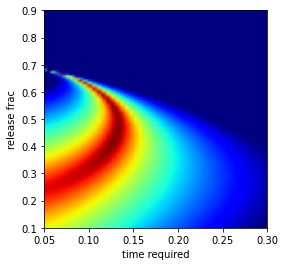

In [7]:
plt.figure(figsize=(4, 4))

X, Y = np.meshgrid(np.linspace(0.05, 0.3, 50), np.linspace(0.1, 0.9, 100))
Z = np.zeros_like(X).flatten()
for idx, (x, y) in enumerate(zip(X.flatten(), Y.flatten())):
    Z[idx] = 1 - min(np.log(1 + throw_objective([x, y])), 6)
Z = Z.reshape(X.shape)

plt.pcolormesh(X,Y,Z, shading='gouraud', cmap='jet')
plt.xlabel("time required")
plt.ylabel("release frac")
plt.show();

#ax = plt.axes(projection="3d")
#ax.view_init(elev=20., azim=-45)
#ax.plot_surface(X, Y, Z, cmap="jet");
#ax.set_xlabel("time required");
#ax.set_ylabel("release frac");

# Generate trajectories in joint angle space with timings from above

### End-effector trajectory
Gripper trajectory also defined for reference but we used a closed loop controller for the gripper

In [8]:
# plan pickup
t_lst, q_knots, total_time = plan_pickup(T_world_robotInitial, T_world_gripperObject,
    t_goToObj=t_goToObj,
    t_holdObj=t_holdObj,
    t_goToPreobj=t_goToPreobj
)

# clear the bins via a waypoint
T_world_hackyWayPoint = RigidTransform(
    p=[-.6, -0.0, 0.6],
    R=RotationMatrix.MakeXRotation(-np.pi/2.0), #R_WORLD_PRETHROW, #RotationMatrix.MakeXRotation(-np.pi/2.0),
)
t_lst, q_knots = add_go_to_pose_via_jointinterpolation(
    T_world_robotInitial, 
    T_world_hackyWayPoint, 
    t_start=total_time,
    t_lst=t_lst,
    q_knots=q_knots,
    time_interval_s=t_goToWaypoint
)

# go to prethrow
t_lst, q_knots = add_go_to_ja_via_jointinterpolation(
    pose_to_jointangles(T_world_hackyWayPoint), 
    PRETHROW_JA, 
    t_start=total_time + t_goToWaypoint,
    t_lst=t_lst,
    q_knots=q_knots,
    time_interval_s=t_goToPrethrow,
    hold_time_s=1.0,
)

# go to throw
t_lst, q_knots = add_go_to_ja_via_jointinterpolation(
    PRETHROW_JA,
    THROWEND_JA,
    t_start=total_time + t_goToWaypoint + t_goToPrethrow,
    t_lst=t_lst,
    q_knots=q_knots,
    time_interval_s=t_goToThrowEnd,
    num_samples=30,
    include_end=True
)

# turn trajectory into joint space
q_knots = np.array(q_knots)
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)


'''
Gripper reference trajectory (not used, we use a closed loop controller instead)
'''
# make gripper trajectory
assert t_holdObj > 1.5

gripper_times_lst = np.array([
    0.,
    t_goToObj,
    1.0, # pickup object
    0.25, # pickup object
    t_holdObj - 1.25, # pickup object
    t_goToPreobj,
    t_goToWaypoint,
    t_goToPrethrow,
    release_frac * t_goToThrowEnd,
    1e-9,
    (1 - release_frac) * t_goToThrowEnd,
])
gripper_cumulative_times_lst = np.cumsum(gripper_times_lst)
GRIPPER_OPEN = 0.5
GRIPPER_CLOSED = 0.0
gripper_knots = np.array([
    GRIPPER_OPEN,
    GRIPPER_OPEN,
    GRIPPER_OPEN, # pickup object
    GRIPPER_CLOSED, # pickup object
    GRIPPER_CLOSED, # pickup object
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_OPEN,
    GRIPPER_OPEN,
]).reshape(1, gripper_times_lst.shape[0])
g_traj = PiecewisePolynomial.FirstOrderHold(gripper_cumulative_times_lst, gripper_knots)

### Visualizing trajectories

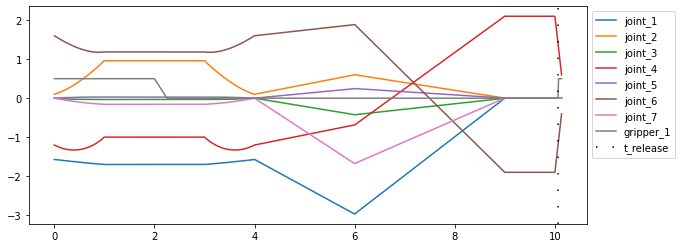

In [9]:
plt.figure(figsize=(10, 4))

#viz_times = np.linspace(q_traj.end_time() - 1.6, q_traj.end_time(), 1000)
viz_times = np.linspace(0, q_traj.end_time(), 1000)
q_plan = np.hstack([q_traj.value(t) for t in viz_times])
g_plan = np.hstack([g_traj.value(t) for t in viz_times])

for idx, r in enumerate(q_plan):
    plt.plot(viz_times, r, label=f"joint_{idx + 1}")
for idx, r in enumerate(g_plan):
    plt.plot(viz_times, r, label=f"gripper_{idx + 1}")
    
plt.axvline(
    x=gripper_cumulative_times_lst[-2],
    color="black", linestyle=(0, (1, 10)), label="t_release"
);
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

# Run simulation

In [10]:
# release when release pose is hit
get_gripper_controller_1 = lambda station_plant: GripperControllerUsingIiwaState(
    plant=station_plant,
    T_world_objectPickup=T_world_gripperObject,
    T_world_prethrow=T_world_prethrowPose,
    T_world_targetRelease=T_world_releasePose,
    dbg_state_prints=True
)

# release when object if released is projected to hit the target ()
get_gripper_controller_2 = lambda station_plant: GripperControllerUsingIiwaStateV2(
    plant=station_plant,
    gripper_to_object_dist=GRIPPER_TO_OBJECT_COM_DIST,
    T_world_objectPickup=T_world_gripperObject,
    T_world_prethrow=T_world_prethrowPose,
    p_world_target=T_world_target.translation(),
    planned_launch_angle=launch_angle,
    launch_angle_thresh=0.03,
    height_thresh=5, # tunable parameter
    dbg_state_prints=True
)

get_gripper_controller_3 = lambda station_plant: GripperControllerUsingIiwaStateV3(
    plant=station_plant,
    gripper_to_object_dist=GRIPPER_TO_OBJECT_COM_DIST,
    T_world_objectPickup=T_world_gripperObject,
    T_world_prethrow=T_world_prethrowPose,
    planned_launch_angle=launch_angle,
    launch_angle_thresh=3 / 180.0 * np.pi, # 3 seems to work well?
    dbg_state_prints=True
)

# do the thing
simulator, station_plant, meshcat, loggers = BuildAndSimulateTrajectory(
    q_traj=q_traj,
    g_traj=g_traj,
    get_gripper_controller=get_gripper_controller_3,
    T_world_objectInitial=T_world_objectInitial, # where to init the object in the world
    T_world_targetBin=T_world_target, # where the ball should hit - aka where the bin will catch it
    zmq_url=zmq_url,
    time_step=1e-3, # target (-6, 6, -1). 1e-3 => overshoot barely, 1e-4 => undershoot barely, look around 7.92-7.94 s in sim
    include_target_bin=False,
    manipuland=OBJECT_TO_TOSS,
    include_hoop=True
)

visualize_transform(
    meshcat,
    "TARGET",
    RigidTransform(RotationMatrix.MakeZRotation(0), P_WORLD_TARGET),
    prefix='',
    length=0.3,
    radius=0.02
)

fly_time = 2
meshcat.start_recording()
print(f"Throw motion should happen from 9.5 seconds to {10 + throw_motion_time} seconds")
print(f"Running for {q_traj.end_time() + fly_time} seconds")
simulator.AdvanceTo(q_traj.end_time() + fly_time)
#simulator.AdvanceTo(1.5)
meshcat.stop_recording()
meshcat.publish_recording()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
Throw motion should happen from 9.5 seconds to 10.13364401911539 seconds
Running for 12.13364401911539 seconds
ROBOT BECAME STATIONARY
ROBOT BECAME MOVING
ROBOT BECAME STATIONARY
ROBOT BECAME MOVING
ROBOT BECAME STATIONARY
ROBOT BECAME MOVING
ROBOT BECAME STATIONARY
ROBOT BECAME MOVING
v2d=(5.00, 8.06) launch_angles=(58.21, 60.00)
v2d=(5.00, 8.06) launch_angles=(58.21, 60.00)
v2d=(4.88, 8.21) launch_angles=(59.27, 60.00)
v2d=(4.76, 8.36) launch_angles=(60.34, 60.00)
v2d=(4.64, 8.51) launch_angles=(61.41, 60.00)
v2d=(4.51, 8.65) launch_angles=(62.49, 60.00)
v2d=(4.37, 8.80) launch_angles=(63.56, 60.00)
RELEASING!
ROBOT BECAME STATIONARY
ROBOT BECAME MOVING
ROBOT BECAME STATIONARY


### Simulation visualization (+ comparison with plan)

Approx release time: 10.108


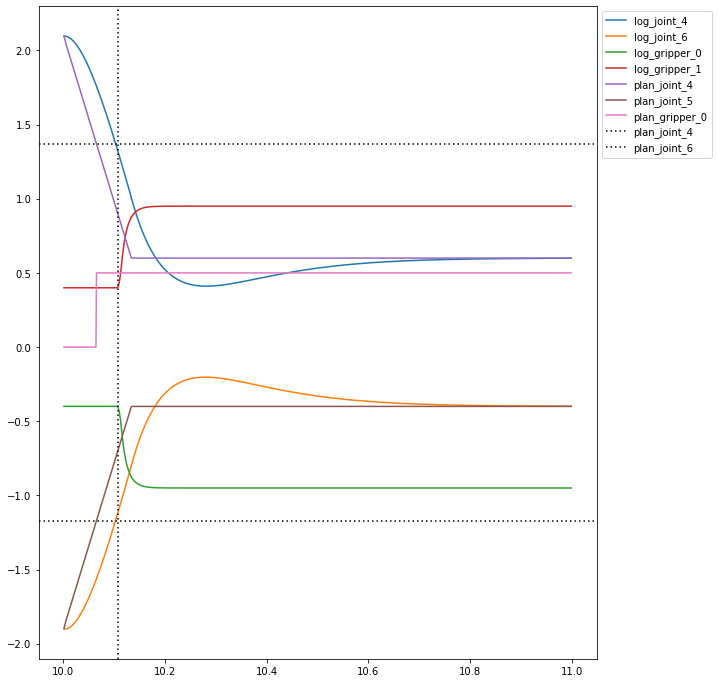

In [11]:
plt.figure(figsize=(10, 12))

all_log_times = loggers["state"].sample_times()
#chosen_idxs = (8 < all_log_times) & (all_log_times < 9)
chosen_idxs = (10 < all_log_times) & (all_log_times < 11)

log_times = loggers["state"].sample_times()[chosen_idxs]
log_states = loggers["state"].data()[:, chosen_idxs]

for idx, r in enumerate(log_states[[10, 12]]):
    plt.plot(log_times, r, label=f"log_joint_{2*idx+4}")
for idx, r in enumerate(log_states[[14, 15]]):
    plt.plot(log_times, 10 *r, label=f"log_gripper_{idx}")
    
q_plan = np.hstack([q_traj.value(t) for t in log_times])
g_plan = np.hstack([g_traj.value(t) for t in log_times])
for idx, r in enumerate(q_plan[[3, 5]]):
    plt.plot(log_times, r, label=f"plan_joint_{idx + 4}")
for idx, r in enumerate(g_plan):
    plt.plot(log_times, r, label=f"plan_gripper_{idx}")

for idx in [4, 6]:
    plt.axhline(
        y=release_ja[idx-1],
        color="black", linestyle=(0, (1, 2)), label=f"plan_joint_{idx}"
    );

approx_release_idx = np.where(log_states[15] > log_states[15].min() + 1e-3)[0][0]
approx_release_time = log_times[approx_release_idx]
print(f"Approx release time: {approx_release_time}")
plt.axvline(
    x=approx_release_time,
    color="black", linestyle=(0, (1, 2)), label=""
);

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

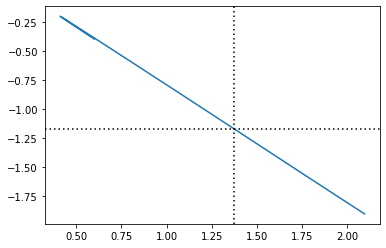

In [12]:
plt.plot(log_states[10], log_states[12]);
plt.axvline(
    x=release_ja[3],
    color="black", linestyle=(0, (1, 2))
);
plt.axhline(
    y=release_ja[5],
    color="black", linestyle=(0, (1, 2))
);

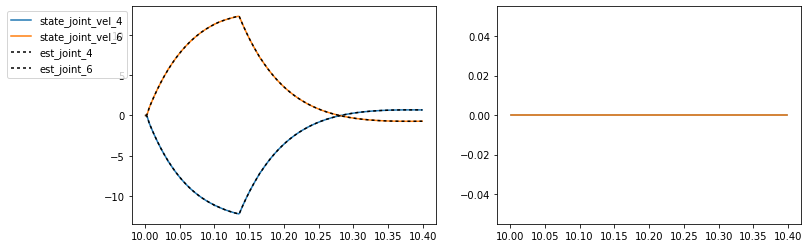

In [13]:
plt.figure(figsize=(12, 4))

all_log_times = loggers["state"].sample_times()
chosen_idxs = (10 < all_log_times) & (all_log_times < 10.4)

chosen_times = loggers["state"].sample_times()[chosen_idxs]
chosen_states = loggers["state"].data()[:, chosen_idxs]
chosen_v_est = loggers["v_est"].data()[:, chosen_idxs]

plt.subplot(1, 2, 1)
for idx, r in enumerate(chosen_states[[25, 27]]):
    plt.plot(chosen_times, r, label=f"state_joint_vel_{2*idx+4}")

for idx, r in enumerate(chosen_v_est[[3, 5]]):
    plt.plot(
        chosen_times, r, label=f"est_joint_{2*idx+4}",
        linestyle=(0, (2, 2)), color="black"
    )
plt.legend(bbox_to_anchor=(0, 1), loc='upper right', ncol=1);

plt.subplot(1, 2, 2)
for idx, (r1, r2) in enumerate(
    zip(chosen_states[[25, 27]], chosen_v_est[[3, 5]])
):
    plt.plot(chosen_times, r1 - r2, label=f"diff_joint_vel_{2*idx+4}")

In [14]:
context = simulator.get_context()

if OBJECT_TO_TOSS == "ball":
    model_str = "sphere"
elif OBJECT_TO_TOSS == "bball":
    model_str = "bball"
elif OBJECT_TO_TOSS == "foam":
    model_str = "foam_brick"
elif OBJECT_TO_TOSS == "rod":
    model_str = "foam_brick"

station_plant.GetPositions(
    station_plant.GetMyContextFromRoot(context),
    station_plant.GetModelInstanceByName(model_str)
)

array([-0.001, -0.193, -0.008,  1.508, -6.314, -0.   , -0.654])

## Determine error for the toss
Make sure you run the simulation above with `include_target_bin` = False

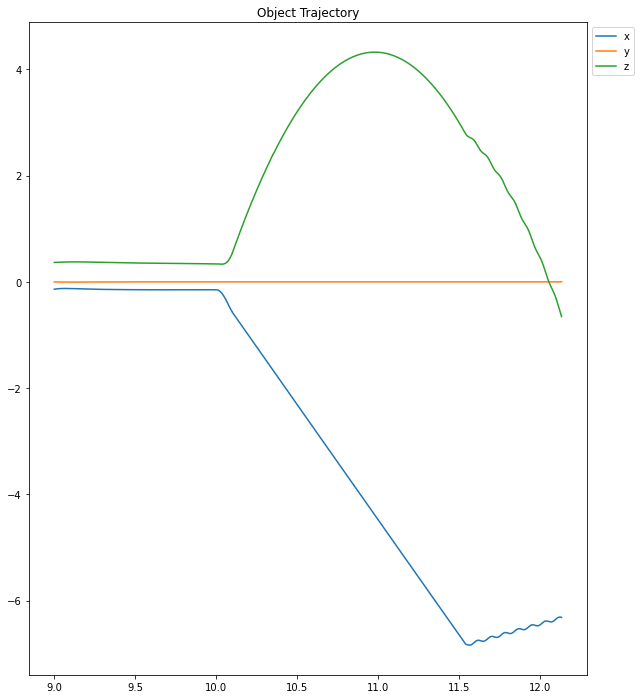

In [15]:
plt.figure(figsize=(10, 12))

all_log_times = loggers["state"].sample_times()
chosen_idxs = (9 < all_log_times) & (all_log_times < 100)

log_times = loggers["state"].sample_times()[chosen_idxs]
log_states = loggers["state"].data()[:, chosen_idxs]

p_objects = np.zeros((len(log_times), 3))
p_objects[:, 0] = log_states[4]
p_objects[:, 1] = log_states[5]
p_objects[:, 2] = log_states[6]
for idx, r in enumerate(log_states[[4, 5, 6]]):
    if idx == 0:
        label="x"
    elif idx == 1:
        label="y"
    elif idx == 2:
        label="z"
    plt.plot(log_times, r, label=label)

plt.title("Object Trajectory")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

In [16]:
deltas = p_objects - P_WORLD_TARGET

dists = np.linalg.norm(deltas, axis=1)
idx = np.argmin(dists)
min_dist = np.min(dists)
print(f"Closest we get to target is: {np.min(dists)} meters at {p_objects[idx]}")

# underthrow or overthrow?
dist_closest_to_origin = np.linalg.norm(p_objects[idx])
dist_target_to_origin = np.linalg.norm(P_WORLD_TARGET)
margin = abs(dist_target_to_origin - dist_closest_to_origin)
is_overthrow = dist_closest_to_origin > dist_target_to_origin
print(f"{'OVERTHROW' if is_overthrow else 'UNDERTHROW'}: Closets point dist: {dist_closest_to_origin}, Target dist: {dist_target_to_origin}")


Closest we get to target is: 0.08298913457310862 meters at [-6.688 -0.     2.944]
UNDERTHROW: Closets point dist: 7.307857397977985, Target dist: 7.386643351347079
